In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import ghibtools as gh
import pandas as pd
import seaborn as sns
import pingouin as pg

In [ ]:
pac_value = 10
freq_modulant = 0.2
amp_modulant = 0.5
freq_modulated = 80
amp_modulated = 0.5
noise_amp = 10
duration = 300
srate = 1000
time, simu_sig = gh.simu_pac_sig(pac_value, freq_modulant, amp_modulant, freq_modulated, amp_modulated, noise_amp, duration, srate)

In [ ]:
pac_values = [1,10,100]
freq_resps = [0.1,0.2]
amp_modulants = [0.5,5,50]
amps_modulated = [0.5,5,50]
noise_amps = [0,5,50]

In [ ]:
fig, ax = plt.subplots()
ax.plot(time, simu_sig)
ax.set_xlim(0,10)
# ax.plot(time, gh.get_amp(simu_sig))

In [ ]:
f, Pxx = gh.spectre(simu_sig, srate, lowest_freq=0.1)
fig, ax = plt.subplots()
ax.plot(f[f < 150], Pxx[f < 150])

In [ ]:
rsp = np.sin(2 * np.pi * 0.2 * time) * np.std(simu_sig)

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(time, rsp)
ax.plot(time, simu_sig)
ax.set_xlim(0,5)

In [51]:
def get_cycle_modulation(features, sig, srate, target_freqs):
    sig_filtered = gh.filter_sig(sig, srate, target_freqs[0], target_freqs[1])
    amplitude = gh.get_amp(sig_filtered)
    MIs = np.zeros((features.shape[0]))
    for c, row in features.iterrows():
        start = int(row['start'])
        stop = int(row['stop'])
        amplitude_of_cycle = amplitude[start:stop]
        norm_values = np.zeros((amplitude_of_cycle.size))
        for i in range(amplitude_of_cycle.size):
            norm_values[i] = amplitude_of_cycle[i] / amplitude_of_cycle.sum()
        MIs[c] = gh.Modulation_Index(norm_values)
    return MIs

In [52]:
def get_respi_mi(rsp, sig, freq_modulated, semibandwidth_filter = 5, method = 'proportion'):
    lowcut = freq_modulated - semibandwidth_filter
    highcut = freq_modulated + semibandwidth_filter
    sig_filtered = gh.filter_sig(sig, srate,lowcut , highcut)
    amp_sig = gh.get_amp(sig_filtered)

    inspi_mask = rsp > 0
    expi_mask = rsp < 0
    inspi_amp = np.mean(simu_sig[inspi_mask])
    expi_amp = np.mean(simu_sig[expi_mask])

    if method == 'proportion_i':
        mi = np.abs((inspi_amp - expi_amp) / (inspi_amp))
    elif method == 'proportion_full':
        mi = np.abs((inspi_amp - expi_amp) / (inspi_amp + expi_amp))
    elif method == 'proportion_mean':
        mi = np.abs((inspi_amp - expi_amp) / np.mean(amp_sig))
    elif method == 'tort_mi':
        features = gh.get_resp_features(rsp, srate, verbose=False)
        MIs = np.zeros((features.shape[0]))
        for c, row in features.iterrows():
            start = int(row['start'])
            stop = int(row['stop'])
            amplitude_of_cycle = amp_sig[start:stop]
            norm_values = np.zeros((amplitude_of_cycle.size))
            for i in range(amplitude_of_cycle.size):
                norm_values[i] = amplitude_of_cycle[i] / amplitude_of_cycle.sum()
            MIs[c] = gh.Modulation_Index(norm_values)
        mi = np.mean(MIs)

    return mi

In [ ]:
methods = ['proportion_i', 'proportion_full','proportion_mean','tort_mi']

rows = []
for pac_value in pac_values:
    print(pac_value)
    for freq_rsp in freq_resps:
        print(freq_rsp)
        for amp_modulant in amp_modulants:
            for amp_modulated in amps_modulated:
                for noise_amp in noise_amps:
                    time, sig = gh.simu_pac_sig(pac_value, freq_rsp, amp_modulant, freq_modulated, amp_modulated, noise_amp, duration, srate)
                    rsp = np.cos(2 * np.pi * freq_rsp * time) * amp_modulant
                    for method in methods:
                        mi = get_respi_mi(rsp, sig, freq_modulated, semibandwidth_filter = 5, method = method)
                        rows.append([pac_value,freq_rsp,amp_modulant,amp_modulated,noise_amp,method,mi])
results = pd.DataFrame(rows, columns = ['pac_value','freq_rsp','amp_modulant','amp_modulated','noise_amp','method','mi'])


In [ ]:
results = pd.read_excel('../Tables/test_mis.xlsx', index_col = 0)

In [ ]:
results

In [ ]:
# results.to_excel('../test_mis.xlsx')

In [ ]:
results.groupby('freq_rsp').mean()

In [53]:
def variation_coefficient(df, predictors, outcome, show = False):
    rows = []
    for predictor in predictors:
        rows.append([predictor, df.groupby(predictor).mean()[outcome].std()])

    df_return = pd.DataFrame(rows, columns = ['col','var coef'])
    if show:
        df_return.set_index('col').sort_values(by = 'var coef', ascending = False).plot.bar()
        plt.show()
    return df_return

In [ ]:
results

In [ ]:
results.groupby(['noise_amp','method']).mean()

In [ ]:
var_coefs = variation_coefficient(df=results, predictors = ['pac_value','freq_rsp','amp_modulant','amp_modulated','noise_amp','method'], outcome = 'mi', show = True)

In [ ]:
sns.pointplot(data=results, x = 'freq_rsp', y = 'mi', hue = 'method')

In [ ]:
sns.pointplot(data=results[results['method'] == 'tort_mi'], x = 'freq_rsp', y = 'mi')

In [ ]:
sns.pointplot(data=results[results['method'] == 'proportion_mean'], x = 'freq_rsp', y = 'mi')

In [77]:
methods = ['proportion_i', 'proportion_full','proportion_mean','tort_mi']
pac_value = 10
amp_modulant = 5
amp_modulated = 0.5
freq_modulated = 80
freq_rsp = 0.3
freq_modulants = [0.1,0.2,0.3,0.4,0.5,1,1.5,2,5]
noise_amps = [0,1,10,100]

da = None
rows = []
for freq_modulant in freq_modulants:
    print(freq_modulant)
    for noise_amp in noise_amps:
        time, sig = gh.simu_pac_sig(pac_value, freq_modulant, amp_modulant, freq_modulated, amp_modulated, noise_amp, duration, srate)

        rsp = np.cos(2 * np.pi * freq_rsp * time) * amp_modulant
        if da is None:
            da = gh.init_da({'freq_modulant':freq_modulants, 'noise_amp':noise_amps, 'time':time}).assign_attrs({'rsp':rsp})
        da.loc[freq_modulant,noise_amp,:] = sig
        for method in methods:
            mi = get_respi_mi(rsp, sig, freq_modulated, semibandwidth_filter = 5, method = method)
            rows.append([freq_modulant,noise_amp,method,mi])
results_2 = pd.DataFrame(rows, columns = ['freq_modulant','noise_amp','method','mi'])

0.1
0.2
0.3
0.4
0.5
1
1.5
2
5


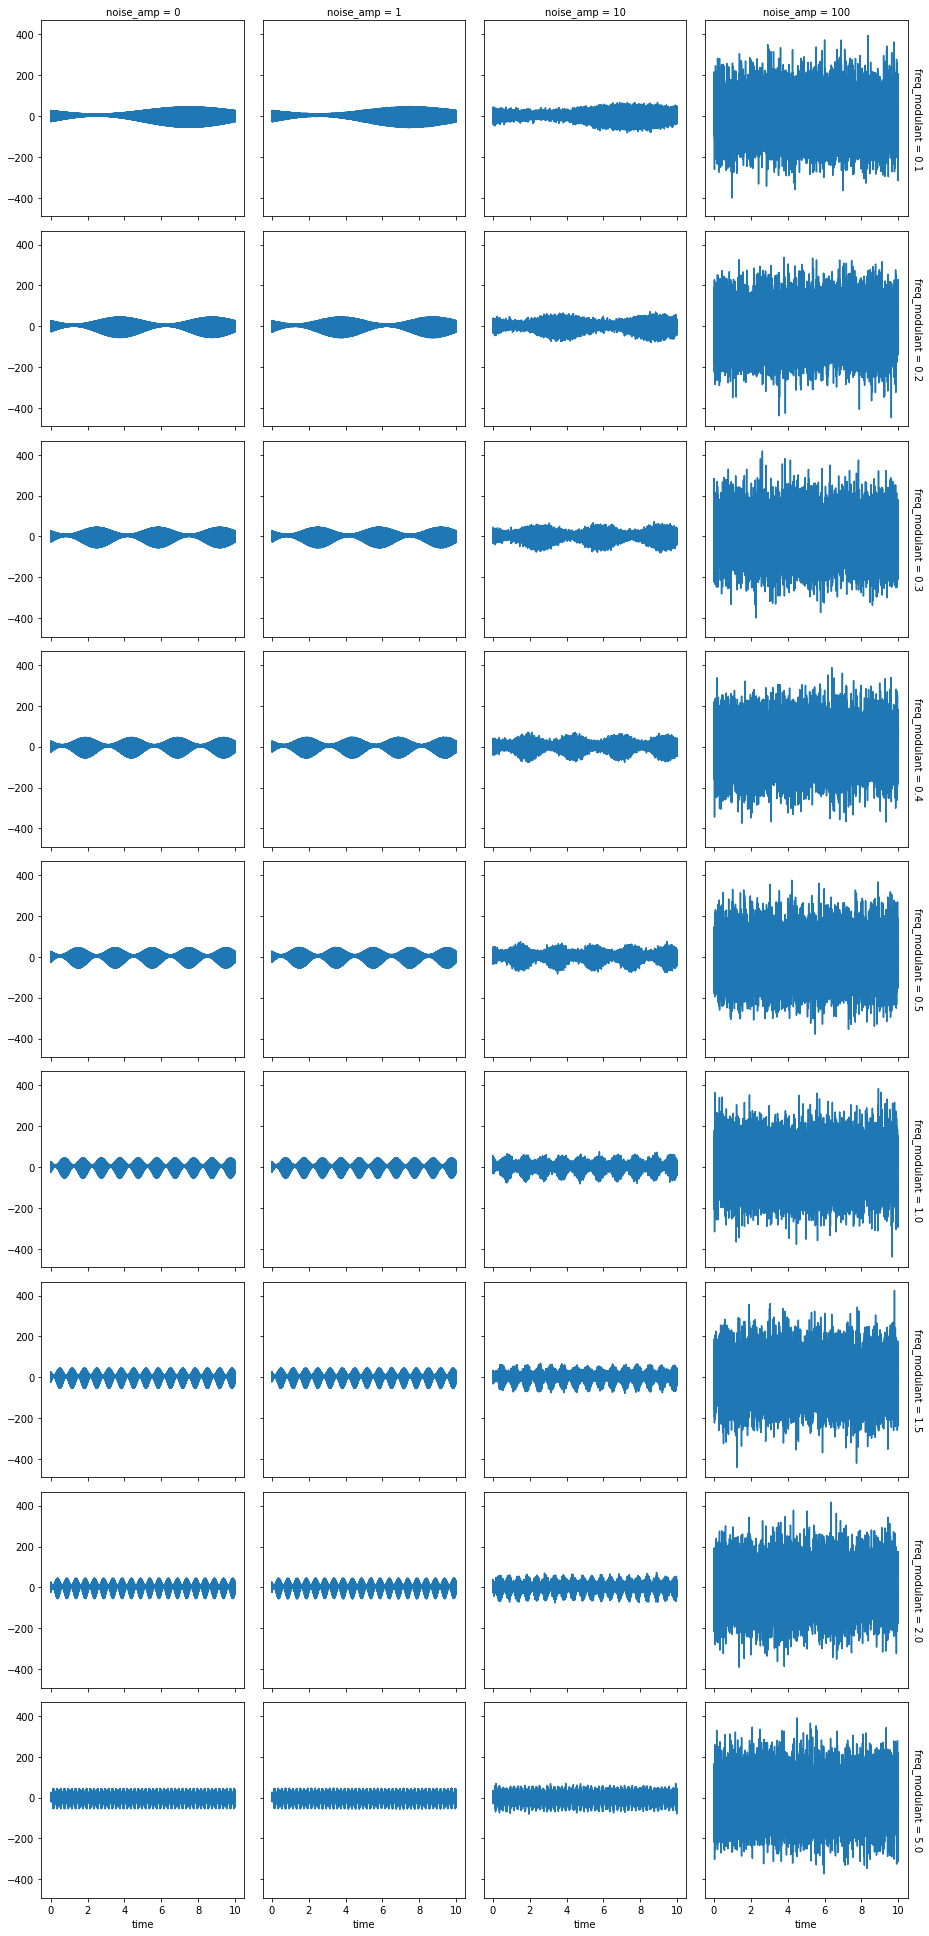

In [78]:
da.loc[:,:,0:10].plot(x='time', col = 'noise_amp', row = 'freq_modulant')

(0.0, 10.0)

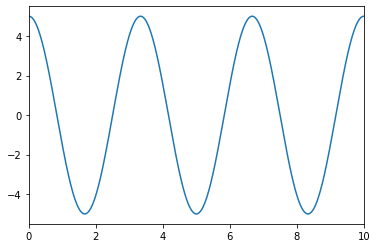

In [82]:
fig, ax = plt.subplots()
ax.plot(time, da.attrs['rsp'])
ax.set_xlim(0,10)

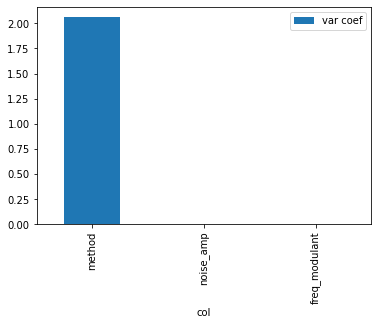

,col,var coef
0,freq_modulant,0.000551
1,noise_amp,0.000648
2,method,2.062550


In [83]:
variation_coefficient(df=results_2, predictors = ['freq_modulant','noise_amp','method'], outcome = 'mi', show = True)

In [84]:
results_2.groupby(['method','noise_amp']).mean()

freq_modulant        mi
method          noise_amp                         
proportion_full 0               1.222222  4.382414
                1               1.222222  4.382414
                10              1.222222  4.382414
                100             1.222222  4.382414
proportion_i    0               1.222222  1.628420
                1               1.222222  1.628420
                10              1.222222  1.628420
                100             1.222222  1.628420
proportion_mean 0               1.222222  0.000511
                1               1.222222  0.000511
                10              1.222222  0.000508
                100             1.222222  0.000353
tort_mi         0               1.222222  0.021697
                1               1.222222  0.021694
                10              1.222222  0.021599
                100             1.222222  0.016635

In [85]:
results_2

,freq_modulant,noise_amp,method,mi
0,0.1,0,proportion_i,1.628420
1,0.1,0,proportion_full,4.382414
2,0.1,0,proportion_mean,0.000511
3,0.1,0,tort_mi,0.014732
4,0.1,1,proportion_i,1.628420
...,...,...,...,...
139,5.0,10,tort_mi,0.022750
140,5.0,100,proportion_i,1.628420
141,5.0,100,proportion_full,4.382414
142,5.0,100,proportion_mean,0.000353


<AxesSubplot:xlabel='freq_modulant', ylabel='mi'>

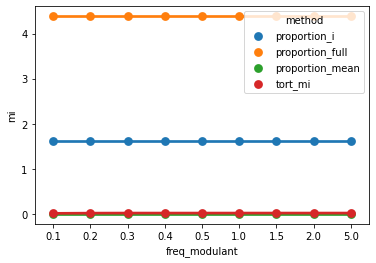

In [86]:
sns.pointplot(data=results_2, x = 'freq_modulant',y = 'mi', hue = 'method')

<AxesSubplot:xlabel='noise_amp', ylabel='mi'>

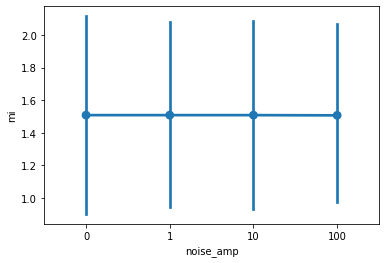

In [87]:
sns.pointplot(data=results_2, x = 'noise_amp',y = 'mi')